### Predicting Loan Approval with Machine Learning

---

### Meredith A. Hughes
### Sruthi Vemavarapu
### Massara Terfassa

---


#### STEP 1 - Environment setup and data loading

**Purpose:** Import libraries, set basic options, load the CSV file, normalize column names, and create a working copy of the data for later steps.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay, 
    roc_curve,
    auc,
    classification_report,
)


from xgboost import XGBClassifier  # requires: pip install xgboost

# Set random seed so results are reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Dataframe and plot display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Path to the CSV file (update if the file moves)
CSV_PATH = Path( r"data\loan_approval_dataset.csv")

# Check to make sure the file exists
assert CSV_PATH.exists(), f"CSV file not found at: {CSV_PATH}"

# Load the raw data
df_raw = pd.read_csv(CSV_PATH)

#  Convert column names to lower_snake_case
def to_snake(s: str) -> str:
    return (
            s.strip()
             .lower()
             .replace(" ", "_")
             .replace("-", "_")
           )

# Normalize all column names
df_raw.columns = [to_snake(c) for c in df_raw.columns]

print(f"Rows: {df_raw.shape[0]} | Columns: {df_raw.shape[1]}")
print("\nDtypes:")
print(df_raw.dtypes)

# Check for missing values
print("\nNull counts by column:")
print(df_raw.isna().sum())

# Create a working copy for the rest of the notebook
df = df_raw.copy()
print("\nWorking copy 'df' created.")

# Initial Data Inspection
display(df_raw.head(10))

Rows: 4269 | Columns: 13

Dtypes:
loan_id                      int64
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Null counts by column:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Working copy 'df' created.


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
5,6,0,Graduate,Yes,4800000,13500000,10,319,6800000,8300000,13700000,5100000,Rejected
6,7,5,Graduate,No,8700000,33000000,4,678,22500000,14800000,29200000,4300000,Approved
7,8,2,Graduate,Yes,5700000,15000000,20,382,13200000,5700000,11800000,6000000,Rejected
8,9,0,Graduate,Yes,800000,2200000,20,782,1300000,800000,2800000,600000,Approved
9,10,5,Not Graduate,No,1100000,4300000,10,388,3200000,1400000,3300000,1600000,Rejected


### Overall Loan Status Distribution

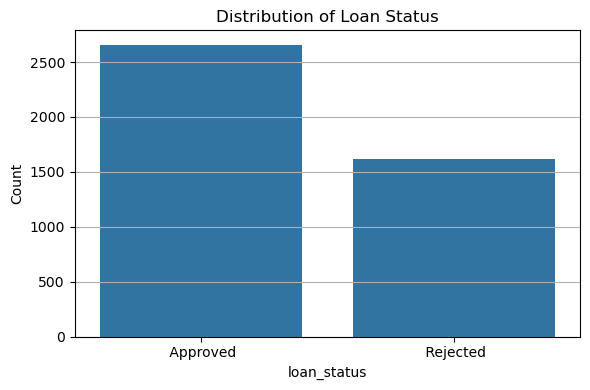

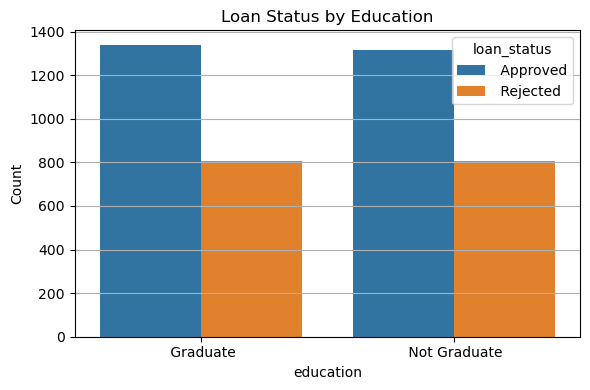

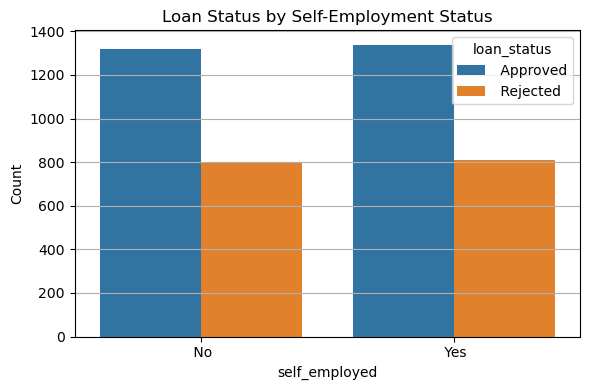

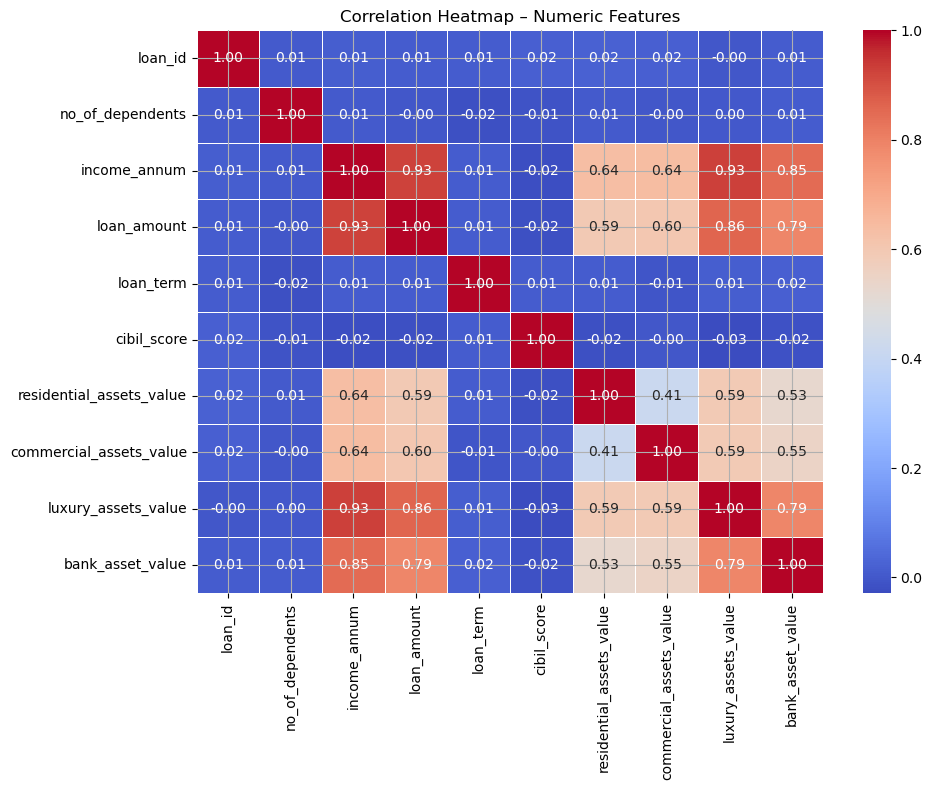

In [2]:
# ============================================
#  Distribution of Loan Application Outcomes
# ============================================

# Overall loan_status distribution
# This plot shows the overall balance between approved and rejected loan applications in the dataset.
plt.figure(figsize=(6, 4))
sns.countplot(x="loan_status", data=df_raw)
plt.title("Distribution of Loan Status")
plt.xlabel("loan_status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Loan Approval Outcomes by Education Level
# This visualization compares approval rates between Graduate and Not Graduate applicants.
plt.figure(figsize=(6, 4))
sns.countplot(x="education", hue="loan_status", data=df_raw)
plt.title("Loan Status by Education")
plt.xlabel("education")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Loan Approval Outcomes by Self-Employment Status
# This plot highlights whether self-employed applicants experience different approval patterns.
plt.figure(figsize=(6, 4))
sns.countplot(x="self_employed", hue="loan_status", data=df_raw)
plt.title("Loan Status by Self-Employment Status")
plt.xlabel("self_employed")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================
#  Correlation heatmap (numeric features only)
# ============================================

# Selecting only numeric columns from the raw dataframe
numeric_cols = df_raw.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df_raw[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation numbers
    fmt=".2f",         # format to 2 decimal places
    cmap="coolwarm",
    linewidths=0.5,    
    cbar=True
)
plt.title("Correlation Heatmap – Numeric Features")
plt.tight_layout()
plt.show()

---


#### STEP 2 - Target variable and categorical encodings

**Purpose:** Create the numeric target (`loan_status_numeric`), encode the `education` and `self_employed` columns , and prepare the final feature sets for modeling.


In [3]:
# Original and numeric target column names
TARGET_ORIG = "loan_status"
TARGET_NUM = "loan_status_numeric"

# Money-Based features (will be log-transformed and scaled later)
money_cols = [
              "income_annum",
              "loan_amount",
              "residential_assets_value",
              "commercial_assets_value",
              "luxury_assets_value",
              "bank_asset_value",
             ]

# Other numeric features that will be standardized later
struct_numeric_cols = [
                       "no_of_dependents",
                       "loan_term",
                       "cibil_score",
                      ]

# Categorical columns before encoding
cat_cols = ["education", "self_employed"]

# Quick check that all expected columns are present
for c in money_cols + struct_numeric_cols + cat_cols + [TARGET_ORIG]:
    assert c in df.columns, f"Expected column missing: {c}"

# 2.1 – loan_status -> numeric target (Approved=1, Rejected=0)
status_map = {"approved": 1, "rejected": 0}
df[TARGET_NUM] = (
    df[TARGET_ORIG]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(status_map)
    .astype(int)
)

# 2.2 – education -> education_graduate (1 = Graduate, 0 = Not Graduate)
df["education_graduate"] = (
    df["education"].astype(str).str.strip().str.lower() == "graduate"
).astype(int)

# 2.3 – self_employed -> self_employed_yes (one-hot with drop_first)
df["self_employed"] = df["self_employed"].astype(str).str.strip().str.lower()
self_dummies = pd.get_dummies(
    df["self_employed"],
    prefix="self_employed",
    drop_first=True
)

# Some datasets might not contain "yes" after drop_first, so handle that safely
if "self_employed_yes" in self_dummies.columns:
    df["self_employed_yes"] = self_dummies["self_employed_yes"].astype(int)
else:
    df["self_employed_yes"] = 0

# Drop original categorical columns (we now use the encoded versions)
df.drop(columns=["education", "self_employed"], inplace=True)

# Feature groups after encoding
engineered_cats = ["education_graduate", "self_employed_yes"]

print("Columns after encoding:")
print(df.columns.tolist())

print("\nClass balance for loan_status_numeric (1 = Approved):")
print(df[TARGET_NUM].value_counts(normalize=True).round(4))

Columns after encoding:
['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status', 'loan_status_numeric', 'education_graduate', 'self_employed_yes']

Class balance for loan_status_numeric (1 = Approved):
loan_status_numeric
1    0.6222
0    0.3778
Name: proportion, dtype: float64


---

#### STEP 3 - Preprocessing: handle negative assets, log transform, and scaling

**Purpose:** Identify and fix negative values in `residential_assets_value`, create a flag for those rows, and build a preprocessing transformer that (1) applies a clipped log transform to money fields, (2) standardizes numeric features, and (3) passes binary features through unchanged.

In [4]:
# 3.1 – Add a flag for negative residential assets and fix the values
NEG_FLAG = "residential_assets_value_was_negative"

# Flag rows where residential_assets_value was negative
df[NEG_FLAG] = (df["residential_assets_value"] < 0).astype(int)

# Replace negative residential_assets_value with 0 so log1p is valid
df.loc[df["residential_assets_value"] < 0, "residential_assets_value"] = 0

print("Number of rows with negative residential_assets_value originally:", df[NEG_FLAG].sum())
print("Minimum residential_assets_value after fix:", df["residential_assets_value"].min())

# 3.2 – Update feature lists
engineered_flags = [NEG_FLAG]             # new binary flag

# Final feature list used for modeling
feature_cols = money_cols + struct_numeric_cols + engineered_cats + engineered_flags

print("\nFinal feature columns:")
print(feature_cols)

# 3.3 – Define safe log1p and build the preprocessing transformer
def clip0_log1p(X):
    """Clip negatives to 0, then apply log1p."""
    return np.log1p(np.clip(X, a_min=0, a_max=None))

safe_log1p = FunctionTransformer(clip0_log1p, validate=False)

preprocess = ColumnTransformer(
    transformers=[
        # Money columns: clip -> log1p -> standardize
        ("money_log_scale", Pipeline([
            ("log1p", safe_log1p),
            ("scaler", StandardScaler())
        ]), money_cols),
        # Other numeric columns: standardize
        ("numeric_scale", StandardScaler(), struct_numeric_cols),
        # Binary features and flag: passthrough
        ("binary_passthrough", "passthrough", engineered_cats + engineered_flags),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("\nPreprocessing transformer created.")

# 3.4 – Preview transformed output (fit on full data only for a quick check)
X_preview = df[feature_cols].copy()
Xt_preview = preprocess.fit_transform(X_preview)

print("Transformed shape (preview):", Xt_preview.shape)

out_feature_names = (
    [f"{c}__log1p_scaled" for c in money_cols] +
    [f"{c}__scaled" for c in struct_numeric_cols] +
    engineered_cats + engineered_flags
)
print("Output feature order (preview):")
print(out_feature_names)

# 3.5 – Prepare X and y for the train/test split (Step 4)
X = df[feature_cols].copy()
y = df[TARGET_NUM].copy()

print("\nPrepared X and y for splitting.")
print("X shape:", X.shape, "| y shape:", y.shape)

df.head(10)


Number of rows with negative residential_assets_value originally: 28
Minimum residential_assets_value after fix: 0

Final feature columns:
['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'no_of_dependents', 'loan_term', 'cibil_score', 'education_graduate', 'self_employed_yes', 'residential_assets_value_was_negative']

Preprocessing transformer created.
Transformed shape (preview): (4269, 12)
Output feature order (preview):
['income_annum__log1p_scaled', 'loan_amount__log1p_scaled', 'residential_assets_value__log1p_scaled', 'commercial_assets_value__log1p_scaled', 'luxury_assets_value__log1p_scaled', 'bank_asset_value__log1p_scaled', 'no_of_dependents__scaled', 'loan_term__scaled', 'cibil_score__scaled', 'education_graduate', 'self_employed_yes', 'residential_assets_value_was_negative']

Prepared X and y for splitting.
X shape: (4269, 12) | y shape: (4269,)


,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,loan_status_numeric,education_graduate,self_employed_yes,residential_assets_value_was_negative
0,1,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1,1,0,0
1,2,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,0,0,1,0
2,3,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0,1,0,0
3,4,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0,1,0,0
4,5,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,0,0,1,0
5,6,0,4800000,13500000,10,319,6800000,8300000,13700000,5100000,Rejected,0,1,1,0
6,7,5,8700000,33000000,4,678,22500000,14800000,29200000,4300000,Approved,1,1,0,0
7,8,2,5700000,15000000,20,382,13200000,5700000,11800000,6000000,Rejected,0,1,1,0
8,9,0,800000,2200000,20,782,1300000,800000,2800000,600000,Approved,1,1,1,0
9,10,5,1100000,4300000,10,388,3200000,1400000,3300000,1600000,Rejected,0,0,0,0


---

#### STEP 4 – Train/test split and cross-validation setup

**Purpose:** Split the data into training and test sets using a 70/30 stratified split, and create a stratified 5-fold cross-validation object that will be reused for all models.


In [5]:
# 4.1 – Stratified 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,           # keep target class ratio similar in train and test
    random_state=RANDOM_STATE
)

print("Train/test split complete.")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# Check that the target distribution is similar in overall, train, and test
print("\nClass ratio for loan_status_numeric (1 = Approved):")
print("Overall:", y.mean().round(4))
print("Train  :", y_train.mean().round(4))
print("Test   :", y_test.mean().round(4))

# 4.2 – Stratified 5-fold cross-validation
cv5 = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

print("\nStratified 5-fold CV object created.")

Train/test split complete.
Train shape: (2988, 12) | Test shape: (1281, 12)

Class ratio for loan_status_numeric (1 = Approved):
Overall: 0.6222
Train  : 0.6222
Test   : 0.6222

Stratified 5-fold CV object created.


---

### STEP 5 - Logistic Regression baseline

**Purpose:** Fit a Logistic Regression model using the preprocessing pipeline, evaluate it with 5-fold cross-validation on the training data, and then measure performance on the test set.

Logistic Regression pipeline created.

Logistic Regression – cross-validation results (per fold):


,fold,accuracy,precision,recall,f1,roc_auc
0,1,0.913043,0.941989,0.916667,0.929155,0.967885
1,2,0.909699,0.929730,0.924731,0.927224,0.971465
2,3,0.899666,0.914894,0.924731,0.919786,0.960344
3,4,0.916248,0.914948,0.954301,0.934211,0.973668
4,5,0.916248,0.934959,0.929919,0.932432,0.962264



Logistic Regression – cross-validation mean ± std:
accuracy : 0.9110 ± 0.0069
precision: 0.9273 ± 0.0121
recall   : 0.9301 ± 0.0144
f1       : 0.9286 ± 0.0056
roc_auc  : 0.9671 ± 0.0057

Test set performance (Logistic Regression):
Accuracy : 0.9126
Precision: 0.9234
Recall   : 0.9373
F1-score : 0.9303
ROC-AUC  : 0.9730


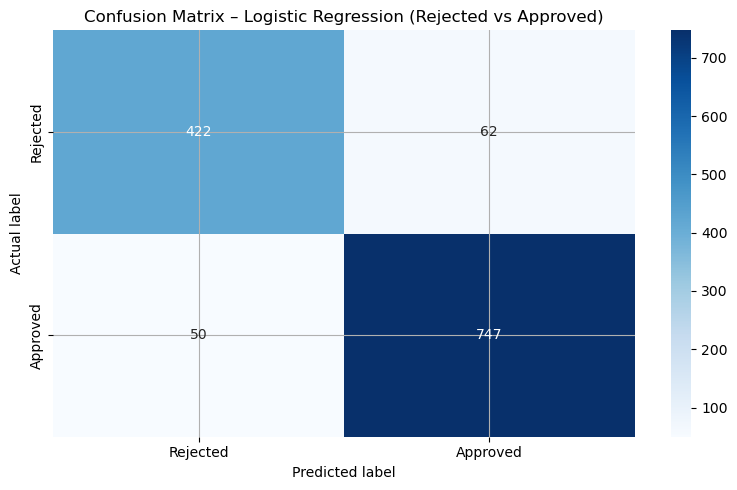

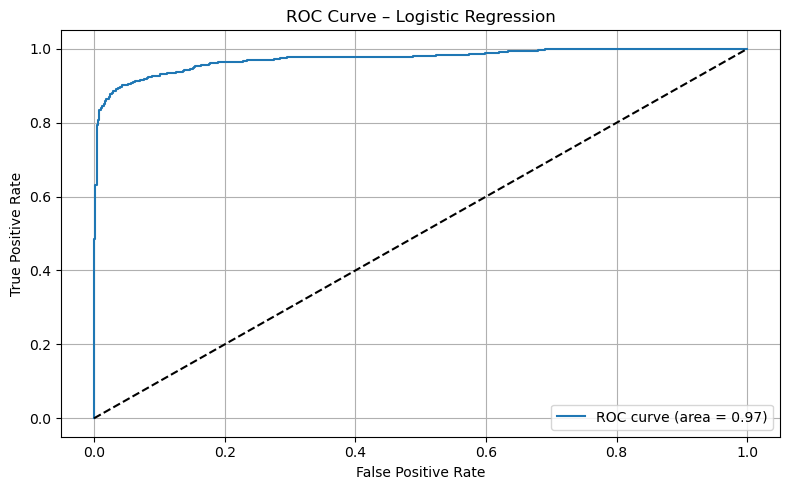

In [6]:
# 5.1 – Build Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])

print("Logistic Regression pipeline created.")

# 5.2 – 5-fold cross-validation on the training set
scoring = {
           "accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"
          }

logreg_cv_results = cross_validate(
    logreg_pipeline,
    X_train,
    y_train,
    cv=cv5,
    scoring=scoring,
    n_jobs=1,              # avoid multiprocessing issues in notebook
    return_train_score=False
)

logreg_cv_df = pd.DataFrame({
    "fold": range(1, cv5.get_n_splits() + 1),
    "accuracy": logreg_cv_results["test_accuracy"],
    "precision": logreg_cv_results["test_precision"],
    "recall": logreg_cv_results["test_recall"],
    "f1": logreg_cv_results["test_f1"],
    "roc_auc": logreg_cv_results["test_roc_auc"],
})

print("\nLogistic Regression – cross-validation results (per fold):")
display(logreg_cv_df)

print("\nLogistic Regression – cross-validation mean ± std:")
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    mean_val = logreg_cv_df[metric].mean()
    std_val = logreg_cv_df[metric].std()
    print(f"{metric:9s}: {mean_val:.4f} ± {std_val:.4f}")

# 5.3 – Fit on full training set and evaluate on test set
logreg_pipeline.fit(X_train, y_train)

logreg_y_pred = logreg_pipeline.predict(X_test)
logreg_y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

logreg_test_accuracy  = accuracy_score(y_test, logreg_y_pred)
logreg_test_precision = precision_score(y_test, logreg_y_pred)
logreg_test_recall    = recall_score(y_test, logreg_y_pred)
logreg_test_f1        = f1_score(y_test, logreg_y_pred)
logreg_test_roc_auc   = roc_auc_score(y_test, logreg_y_proba)

print("\nTest set performance (Logistic Regression):")
print(f"Accuracy : {logreg_test_accuracy:.4f}")
print(f"Precision: {logreg_test_precision:.4f}")
print(f"Recall   : {logreg_test_recall:.4f}")
print(f"F1-score : {logreg_test_f1:.4f}")
print(f"ROC-AUC  : {logreg_test_roc_auc:.4f}")


# 5.4 – Confusion matrix and ROC curve for Logistic Regression
# 1 = Approved, 0 = Rejected
cm_logreg = confusion_matrix(y_test, logreg_y_pred)

plt.figure()
sns.heatmap(
    cm_logreg,
    annot=True,
    fmt="d",
    cbar=True,
    cmap="Blues", 
    xticklabels=["Rejected", "Approved"],  # predicted labels
    yticklabels=["Rejected", "Approved"]   # actual labels
)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix – Logistic Regression (Rejected vs Approved)")
plt.tight_layout()
plt.show()


# 5.5 – ROC curve  
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_y_proba)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f"ROC curve (area = {roc_auc_logreg:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

---

### STEP 6 - Random Forest classifier

**Purpose:** Fit a Random Forest model using the same preprocessing pipeline, evaluate it with 5-fold cross-validation on the training data, and then measure performance on the test set.

Random Forest pipeline created.

Random Forest – cross-validation results (per fold):


,fold,accuracy,precision,recall,f1,roc_auc
0,1,0.974916,0.981132,0.978495,0.979812,0.998454
1,2,0.983278,0.986559,0.986559,0.986559,0.996735
2,3,0.968227,0.970667,0.978495,0.974565,0.990651
3,4,0.983250,0.981383,0.991935,0.986631,0.996726
4,5,0.976549,0.978552,0.983827,0.981183,0.996315



Random Forest – cross-validation mean ± std:
accuracy : 0.9772 ± 0.0063
precision: 0.9797 ± 0.0058
recall   : 0.9839 ± 0.0057
f1       : 0.9817 ± 0.0051
roc_auc  : 0.9958 ± 0.0030

Test set performance (Random Forest):
Accuracy : 0.9859
Precision: 0.9887
Recall   : 0.9887
F1-score : 0.9887
ROC-AUC  : 0.9988


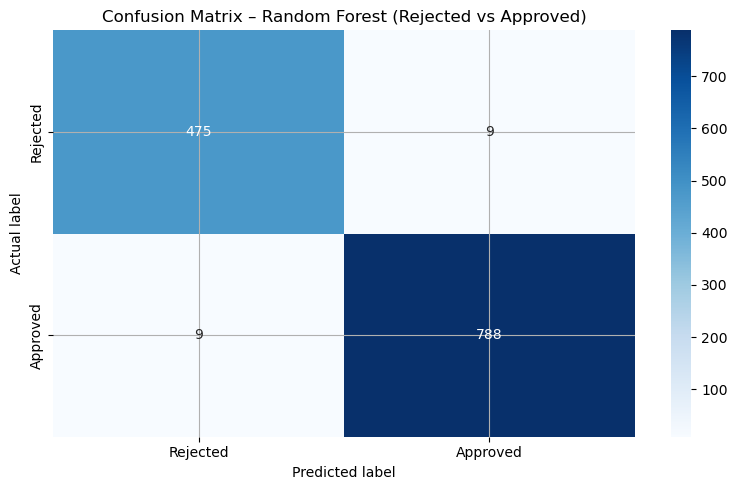

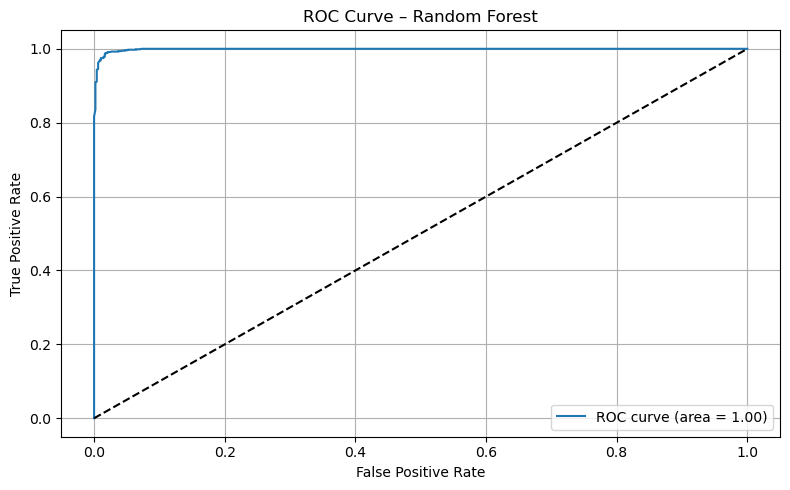

In [7]:
# 6.1 – Build Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=RANDOM_STATE,
        n_jobs=1
    ))
])

print("Random Forest pipeline created.")

# 6.2 - 5-fold cross-validation on the training set
rf_scoring = {
              "accuracy": "accuracy",
              "precision": "precision",
              "recall": "recall",
              "f1": "f1",
              "roc_auc": "roc_auc"
             }

rf_cv_results = cross_validate(
    rf_pipeline,
    X_train,
    y_train,
    cv=cv5,
    scoring=rf_scoring,
    n_jobs=1,              # keep single process for stability in notebook
    return_train_score=False
)

rf_cv_df = pd.DataFrame({
    "fold": range(1, cv5.get_n_splits() + 1),
    "accuracy": rf_cv_results["test_accuracy"],
    "precision": rf_cv_results["test_precision"],
    "recall": rf_cv_results["test_recall"],
    "f1": rf_cv_results["test_f1"],
    "roc_auc": rf_cv_results["test_roc_auc"],
})

print("\nRandom Forest – cross-validation results (per fold):")
display(rf_cv_df)

print("\nRandom Forest – cross-validation mean ± std:")
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    mean_val = rf_cv_df[metric].mean()
    std_val = rf_cv_df[metric].std()
    print(f"{metric:9s}: {mean_val:.4f} ± {std_val:.4f}")

# 6.3 – Fit on full training set and evaluate on test set
rf_pipeline.fit(X_train, y_train)

rf_y_pred = rf_pipeline.predict(X_test)
rf_y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

rf_test_accuracy  = accuracy_score(y_test, rf_y_pred)
rf_test_precision = precision_score(y_test, rf_y_pred)
rf_test_recall    = recall_score(y_test, rf_y_pred)
rf_test_f1        = f1_score(y_test, rf_y_pred)
rf_test_roc_auc   = roc_auc_score(y_test, rf_y_proba)

print("\nTest set performance (Random Forest):")
print(f"Accuracy : {rf_test_accuracy:.4f}")
print(f"Precision: {rf_test_precision:.4f}")
print(f"Recall   : {rf_test_recall:.4f}")
print(f"F1-score : {rf_test_f1:.4f}")
print(f"ROC-AUC  : {rf_test_roc_auc:.4f}")

# 6.4 – Confusion matrix and ROC curve for Random Forest
# 1 = Approved, 0 = Rejected
cm_rf = confusion_matrix(y_test, rf_y_pred)

plt.figure()
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cbar=True,
    cmap="Blues", 
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"]
)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix – Random Forest (Rejected vs Approved)")
plt.tight_layout()
plt.show()


# 6.5 – ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_y_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"ROC curve (area = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


---

### STEP 7 - XGBoost classifier

**Purpose:** Fit an XGBoost classifier using the same preprocessing pipeline, evaluate it with 5-fold cross-validation on the training data, and then measure performance on the test set.

XGBoost pipeline created.

XGBoost – cross-validation results (per fold):


,fold,accuracy,precision,recall,f1,roc_auc
0,1,0.981605,0.991826,0.978495,0.985115,0.999144
1,2,0.981605,0.978780,0.991935,0.985314,0.998085
2,3,0.971572,0.970822,0.983871,0.977303,0.996586
3,4,0.986600,0.986631,0.991935,0.989276,0.995842
4,5,0.979899,0.978667,0.989218,0.983914,0.997460



XGBoost – cross-validation mean ± std:
accuracy : 0.9803 ± 0.0055
precision: 0.9813 ± 0.0081
recall   : 0.9871 ± 0.0058
f1       : 0.9842 ± 0.0043
roc_auc  : 0.9974 ± 0.0013

Test set performance (XGBoost):
Accuracy : 0.9867
Precision: 0.9887
Recall   : 0.9900
F1-score : 0.9893
ROC-AUC  : 0.9988


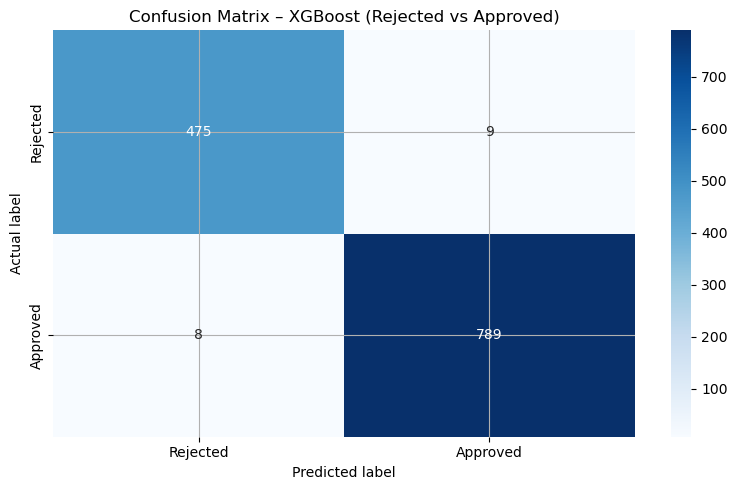

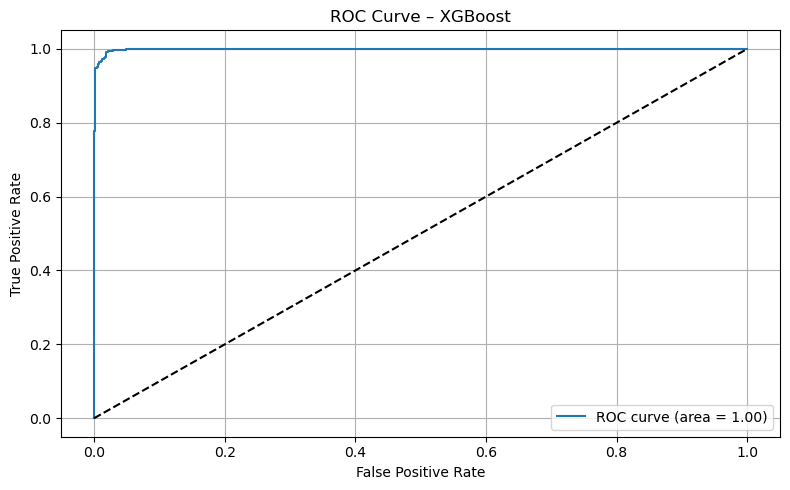

RF importances length: 12
Number of features: 12


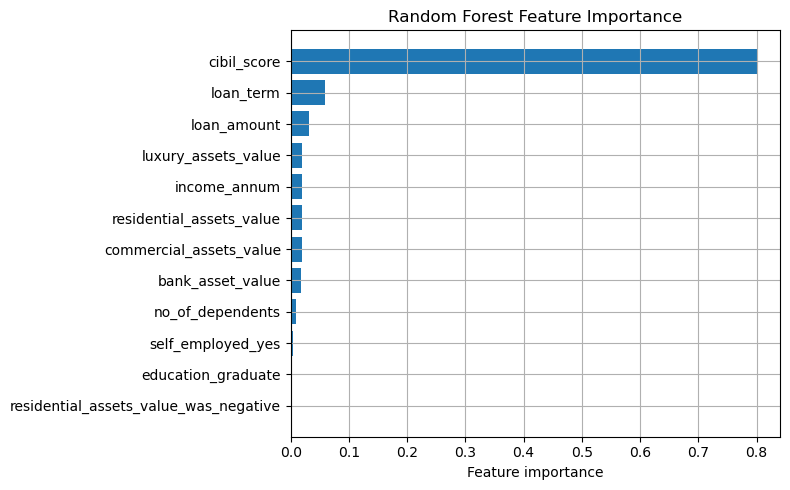

XGB importances length: 12
Number of features: 12


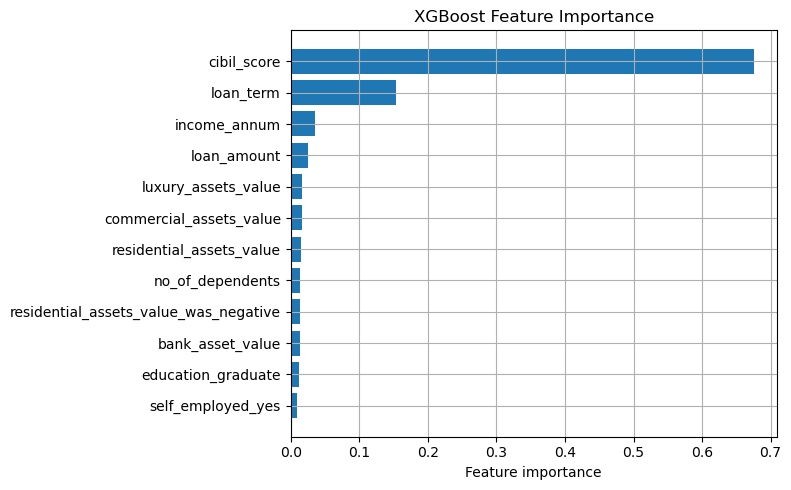

In [8]:
# 7.1 – Build XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=1,
        random_state=RANDOM_STATE,
        tree_method="hist"
    ))
])

print("XGBoost pipeline created.")

# 7.2 – 5-fold cross-validation on the training set
xgb_scoring = {
               "accuracy": "accuracy",
               "precision": "precision",
               "recall": "recall",
               "f1": "f1",
               "roc_auc": "roc_auc"
              }

xgb_cv_results = cross_validate(
    xgb_pipeline,
    X_train,
    y_train,
    cv=cv5,
    scoring=xgb_scoring,
    n_jobs=1,              # keep single process for stability in notebook
    return_train_score=False
)

xgb_cv_df = pd.DataFrame({
    "fold": range(1, cv5.get_n_splits() + 1),
    "accuracy": xgb_cv_results["test_accuracy"],
    "precision": xgb_cv_results["test_precision"],
    "recall": xgb_cv_results["test_recall"],
    "f1": xgb_cv_results["test_f1"],
    "roc_auc": xgb_cv_results["test_roc_auc"],
})

print("\nXGBoost – cross-validation results (per fold):")
display(xgb_cv_df)

print("\nXGBoost – cross-validation mean ± std:")
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    mean_val = xgb_cv_df[metric].mean()
    std_val = xgb_cv_df[metric].std()
    print(f"{metric:9s}: {mean_val:.4f} ± {std_val:.4f}")

# 7.3 – Fit on full training set and evaluate on test set
xgb_pipeline.fit(X_train, y_train)

xgb_y_pred = xgb_pipeline.predict(X_test)
xgb_y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

xgb_test_accuracy  = accuracy_score(y_test, xgb_y_pred)
xgb_test_precision = precision_score(y_test, xgb_y_pred)
xgb_test_recall    = recall_score(y_test, xgb_y_pred)
xgb_test_f1        = f1_score(y_test, xgb_y_pred)
xgb_test_roc_auc   = roc_auc_score(y_test, xgb_y_proba)

print("\nTest set performance (XGBoost):")
print(f"Accuracy : {xgb_test_accuracy:.4f}")
print(f"Precision: {xgb_test_precision:.4f}")
print(f"Recall   : {xgb_test_recall:.4f}")
print(f"F1-score : {xgb_test_f1:.4f}")
print(f"ROC-AUC  : {xgb_test_roc_auc:.4f}")

# 7.4 – Confusion matrix and ROC curve for XGBoost
# 1 = Approved, 0 = Rejected
cm_xgb = confusion_matrix(y_test, xgb_y_pred)

plt.figure()
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cbar=True,
     cmap="Blues", 
    xticklabels=["Rejected", "Approved"],   # predicted labels
    yticklabels=["Rejected", "Approved"]    # actual labels
)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix – XGBoost (Rejected vs Approved)")
plt.tight_layout()
plt.show()


# 7.5 – ROC curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_y_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC curve (area = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Step 7.6 – Random Forest feature importance

import numpy as np

# Get fitted RF model from the pipeline
rf_clf = rf_pipeline.named_steps["clf"]

# Using the same feature columns that were used to build X and X_train
feature_names = X_train.columns

# Sanity check: make sure lengths match
print("RF importances length:", len(rf_clf.feature_importances_))
print("Number of features:", len(feature_names))

importances = rf_clf.feature_importances_

# Sort from least to most important
indices = np.argsort(importances)
sorted_names = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8, 5))
plt.barh(sorted_names, sorted_importances)
plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


# Step 7.7 – XGBoost feature importance

xgb_clf = xgb_pipeline.named_steps["clf"]

feature_names = X_train.columns

print("XGB importances length:", len(xgb_clf.feature_importances_))
print("Number of features:", len(feature_names))

importances = xgb_clf.feature_importances_

indices = np.argsort(importances)
sorted_names = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(8, 5))
plt.barh(sorted_names, sorted_importances)
plt.xlabel("Feature importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()



---

#### STEP 8 - Model comparison summary

**Purpose:** Create a summary table that compares Logistic Regression, Random Forest, and XGBoost on the main test set metrics.

In [9]:
# Final Evaluation and Comparison
# Purpose: Compare Logistic Regression, Random Forest, and XGBoost on the test set.

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

models = [
    ("Logistic Regression", logreg_y_pred, logreg_y_proba),
    ("Random Forest", rf_y_pred, rf_y_proba),
    ("XGBoost", xgb_y_pred, xgb_y_proba),
]

for name, y_pred, y_proba in models:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc,
    })

results_df = pd.DataFrame(results).set_index("Model")
display(results_df.round(3))


,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
Logistic Regression,0.913,0.923,0.937,0.930,0.973
Random Forest,0.986,0.989,0.989,0.989,0.999
XGBoost,0.987,0.989,0.990,0.989,0.999


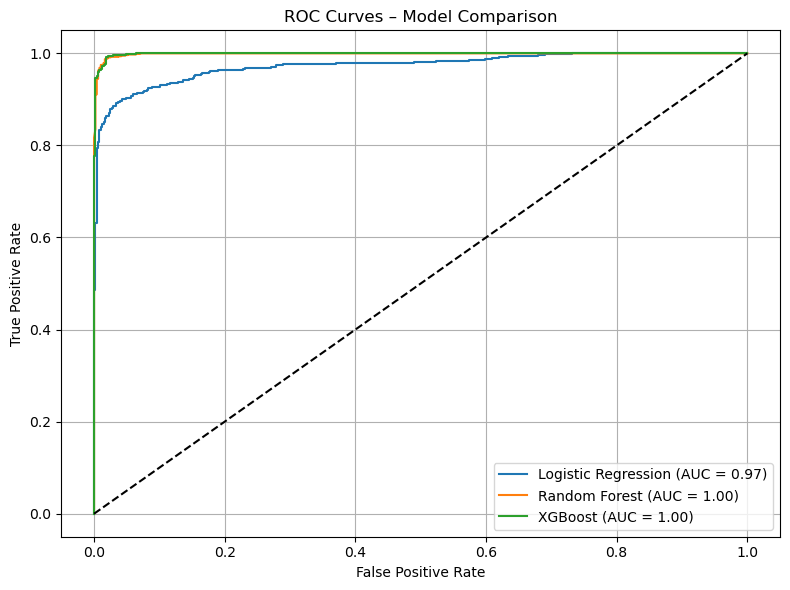

In [10]:
# 8.2 – Combined ROC curves for all models

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_y_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


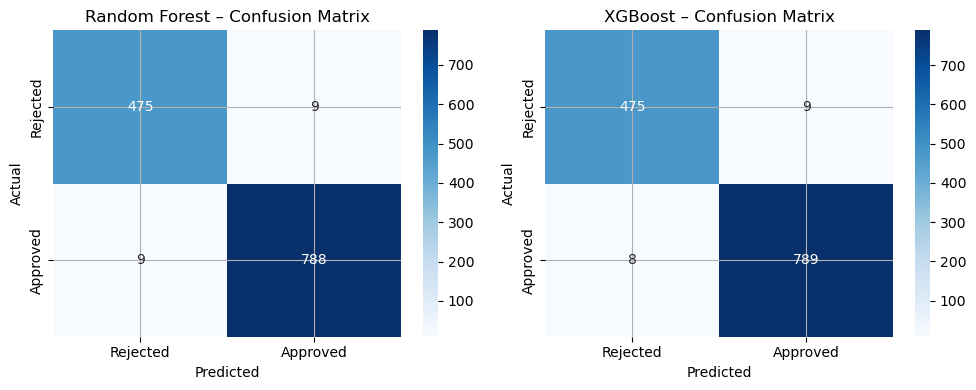

In [11]:
# 8.3 – Confusion matrix comparison: Random Forest vs XGBoost

from sklearn.metrics import confusion_matrix

# Reuse predictions from earlier steps
cm_rf = confusion_matrix(y_test, rf_y_pred)
cm_xgb = confusion_matrix(y_test, xgb_y_pred)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Random Forest confusion matrix
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cbar=True,
    cmap="Blues", 
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"],
    ax=axes[0]
)
axes[0].set_title("Random Forest – Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# XGBoost confusion matrix
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cbar=True,
    cmap="Blues", 
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"],
    ax=axes[1]
)
axes[1].set_title("XGBoost – Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


---

### Summary of Findings

<u>**Logistic Regression**</u>
Logistic Regression performed well and served as a strong baseline model. It achieved over 91% accuracy with solid precision, recall, and F1 scores. However, it was less effective than the tree-based models in capturing the more complex patterns in the data. This was reflected in the slightly lower recall and F1 score.

<u>**Random Forest**</u>
Random Forest achieved very strong results across all metrics. The confusion matrix shows that the model correctly classified almost all Approved and Rejected applications, with only a few misclassifications. The ROC curve was almost a perfect shape, leading to a very high ROC-AUC of 0.999. This indicates that Random Forest was able to separate the two classes extremely well.

<u>**XGBoost**</u>
XGBoost performed at nearly the same level as Random Forest. Both the confusion matrix and ROC curve were almost identical to the Random Forest results. Precision, recall, F1, and ROC-AUC were all very close to their maximum possible values. This suggests that boosted tree methods are well suited for this dataset.

<u>**Final Comparison**</u>

When comparing Random Forest and XGBoost directly, both models produced almost the same classification results. The confusion matrices show a similar pattern of very few errors, and their ROC curves overlap closely. These models clearly outperformed Logistic Regression on this dataset.

Overall, the results indicate that tree-based models, especially Random Forest and XGBoost, are more effective for loan approval prediction. Their ability to model nonlinear interactions and work well with mixed-type data gave them a clear advantage over the linear Logistic Regression model.

---